In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

data_dir = '/content/drive/MyDrive/bt4222_group_6/bt4222_group_6_amazon/data'
project_dir = '/content/drive/MyDrive/bt4222_group_6/bt4222_group_6_amazon'

# Customer Interaction Sparsity Analysis and Motivation for Modified Evaluation Metrics

# Step 1: Load dataset

Previously in step1_data_preprocessing.ipynb, We have split the df_reviews dataset into training, testing and validation samples for each customer, following chronological order and using the early 70% of each customer's interactions for training, followed by the next 15% for validation and the last 15% for testing.

In [ ]:
train_data = pd.read_csv(os.path.join(data_dir,"train_data.csv"))
test_data = pd.read_csv(os.path.join(data_dir,"test_data.csv"))
val_data = pd.read_csv(os.path.join(data_dir,"val_data.csv"))

df_reviews = pd.read_csv(os.path.join(data_dir,"filtered_reviews_with_features_and_clusters.csv"))

# Step 2: Distribution of Customer Purchase Counts in Filtered Validation and Test Sets (For Cluster Models)

In this section, we analyze the number of interactions (purchases) per customer in the validation and test datasets, grouped by cluster, after filtering through prepare_cluster_data() to match the actual evaluation conditions. This filtering ensures that only customers and products seen in the training set are included.

In [ ]:
def prepare_cluster_data(cluster_id, train_df, val_df=None, test_df=None):
    # Cluster-specific train set
    train_cluster = train_df[train_df['cluster'] == cluster_id].reset_index(drop=True)

    # Cluster-local mapping
    customer2idx = {cid: idx for idx, cid in enumerate(train_cluster['customer_id'].unique())}
    item2idx = {pid: idx for idx, pid in enumerate(train_cluster['product_id'].unique())}

    # Map train cluster
    train_cluster['customer_idx'] = train_cluster['customer_id'].map(customer2idx)
    train_cluster['item_idx'] = train_cluster['product_id'].map(item2idx)

    val_cluster, test_cluster = None, None

    # Prepare val cluster
    if val_df is not None:
        val_cluster = val_df[val_df['cluster'] == cluster_id].reset_index(drop=True)
        val_cluster = val_cluster[
            val_cluster['customer_id'].isin(customer2idx) &
            val_cluster['product_id'].isin(item2idx)
        ].reset_index(drop=True)
        val_cluster['customer_idx'] = val_cluster['customer_id'].map(customer2idx)
        val_cluster['item_idx'] = val_cluster['product_id'].map(item2idx)

    # Prepare test cluster
    if test_df is not None:
        test_cluster = test_df[test_df['cluster'] == cluster_id].reset_index(drop=True)
        test_cluster = test_cluster[
            test_cluster['customer_id'].isin(customer2idx) &
            test_cluster['product_id'].isin(item2idx)
        ].reset_index(drop=True)
        test_cluster['customer_idx'] = test_cluster['customer_id'].map(customer2idx)
        test_cluster['item_idx'] = test_cluster['product_id'].map(item2idx)

    return train_cluster, val_cluster, test_cluster, customer2idx, item2idx


In [ ]:
def analyze_customer_activity_distribution_by_cluster(train_data, val_or_test_data, split_name='val', k=10):
    print(f"\n===== Customer Activity Distribution After Filtering: {split_name.upper()} Set =====")
    for cluster_id in sorted(train_data['cluster'].unique()):
        # Proper filtering using prepare_cluster_data
        train_cluster, val_cluster, test_cluster, _, _ = prepare_cluster_data(
            cluster_id,
            train_df=train_data,
            val_df=val_or_test_data if split_name == 'val' else None,
            test_df=val_or_test_data if split_name == 'test' else None
        )

        # Select the correct filtered split based on the split name
        filtered_split = val_cluster if split_name == 'val' else test_cluster

        # Skip if no valid data
        if filtered_split is None or filtered_split.empty:
            print(f"\nCluster {cluster_id} — No data after filtering.")
            continue

        # Count interactions per customer
        customer_counts = filtered_split['customer_id'].value_counts()
        num_customers = customer_counts.shape[0]
        num_under_k = (customer_counts < k).sum()
        percent_under_k = 100 * num_under_k / num_customers if num_customers > 0 else 0

        print(f"\nCluster {cluster_id} — Customers: {num_customers}")
        print(f"Min: {customer_counts.min()}, Max: {customer_counts.max()}, Mean: {customer_counts.mean():.2f}, Median: {customer_counts.median()}")
        print(f"Customers with <{k} interactions: {num_under_k} ({percent_under_k:.1f}%)")
        print(customer_counts.describe())

        # Plot
        plt.figure(figsize=(8, 4))
        sns.histplot(customer_counts, bins=range(1, max(customer_counts.max(), k) + 2), kde=False)
        plt.title(f'Cluster {cluster_id} — {split_name.capitalize()} Set: Purchase Count per Customer')
        plt.xlabel('# of Purchases')
        plt.ylabel('Number of Customers')
        plt.axvline(k, color='red', linestyle='--', label=f'{k} purchases')
        plt.legend()
        plt.tight_layout()
        plt.show()



===== Customer Activity Distribution After Filtering: VAL Set =====

Cluster 0 — Customers: 6029
Min: 1, Max: 2, Mean: 1.10, Median: 1.0
Customers with <10 interactions: 6029 (100.0%)
count    6029.000000
mean        1.101509
std         0.302027
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         2.000000
Name: count, dtype: float64


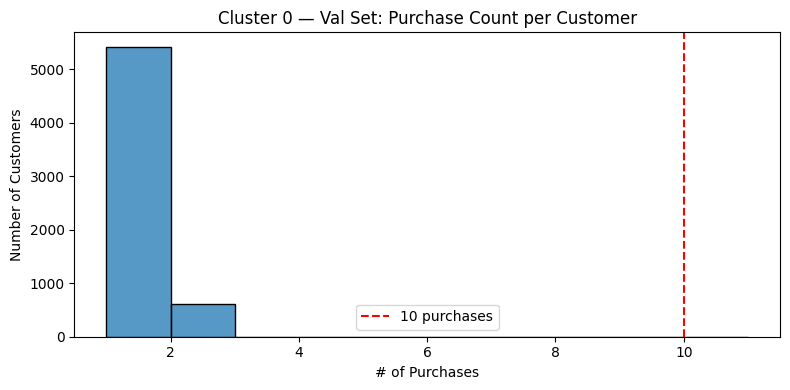


Cluster 1 — Customers: 1428
Min: 1, Max: 1, Mean: 1.00, Median: 1.0
Customers with <10 interactions: 1428 (100.0%)
count    1428.0
mean        1.0
std         0.0
min         1.0
25%         1.0
50%         1.0
75%         1.0
max         1.0
Name: count, dtype: float64


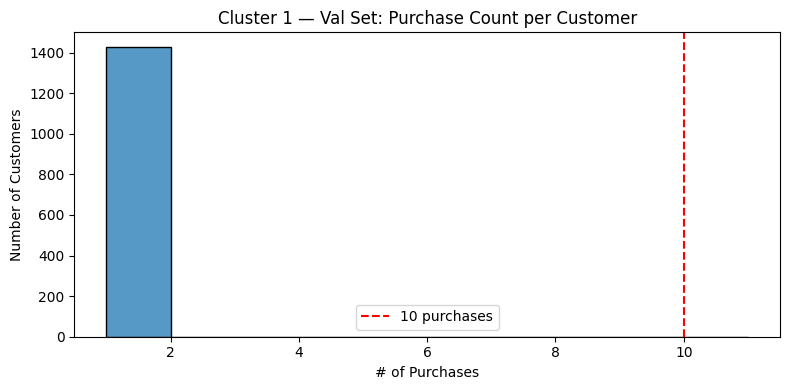


Cluster 2 — Customers: 865
Min: 1, Max: 9, Mean: 1.93, Median: 2.0
Customers with <10 interactions: 865 (100.0%)
count    865.000000
mean       1.926012
std        1.014515
min        1.000000
25%        1.000000
50%        2.000000
75%        2.000000
max        9.000000
Name: count, dtype: float64


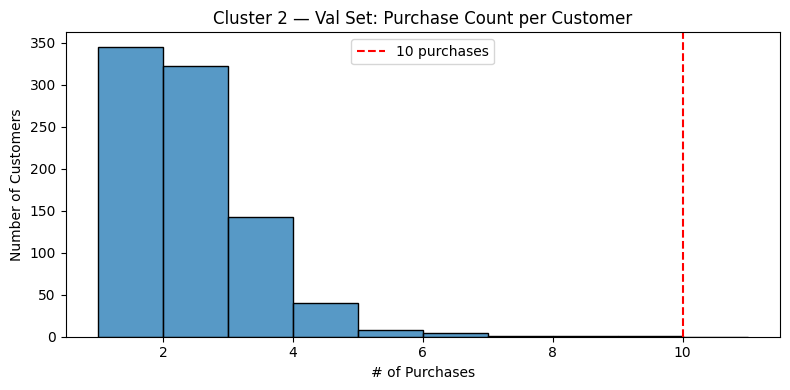


Cluster 3 — Customers: 4118
Min: 1, Max: 1, Mean: 1.00, Median: 1.0
Customers with <10 interactions: 4118 (100.0%)
count    4118.0
mean        1.0
std         0.0
min         1.0
25%         1.0
50%         1.0
75%         1.0
max         1.0
Name: count, dtype: float64


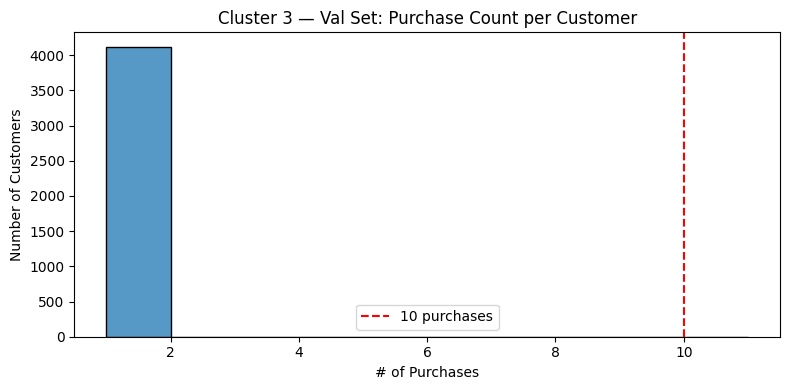


===== Customer Activity Distribution After Filtering: TEST Set =====

Cluster 0 — Customers: 7281
Min: 1, Max: 4, Mean: 1.88, Median: 2.0
Customers with <10 interactions: 7281 (100.0%)
count    7281.000000
mean        1.878451
std         0.708991
min         1.000000
25%         1.000000
50%         2.000000
75%         2.000000
max         4.000000
Name: count, dtype: float64


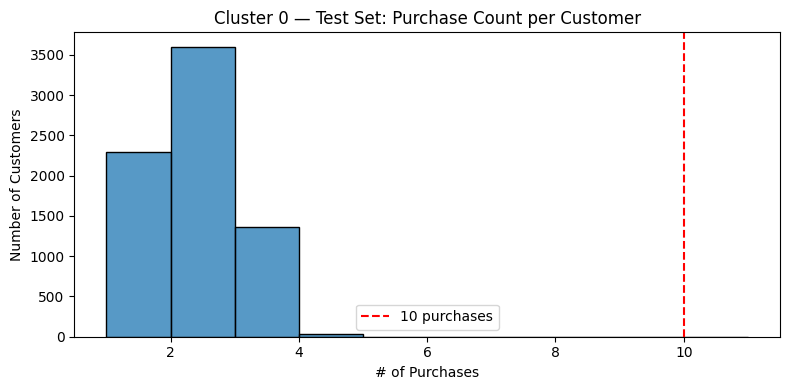


Cluster 1 — Customers: 1991
Min: 1, Max: 3, Mean: 1.33, Median: 1.0
Customers with <10 interactions: 1991 (100.0%)
count    1991.000000
mean        1.331994
std         0.473176
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         3.000000
Name: count, dtype: float64


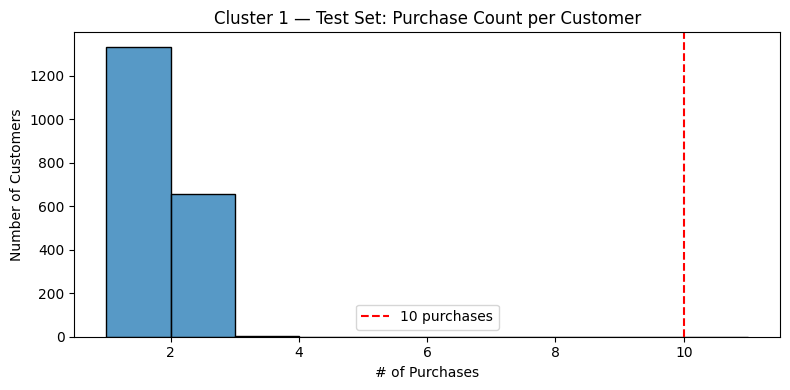


Cluster 2 — Customers: 921
Min: 1, Max: 8, Mean: 2.41, Median: 2.0
Customers with <10 interactions: 921 (100.0%)
count    921.000000
mean       2.413681
std        1.137975
min        1.000000
25%        2.000000
50%        2.000000
75%        3.000000
max        8.000000
Name: count, dtype: float64


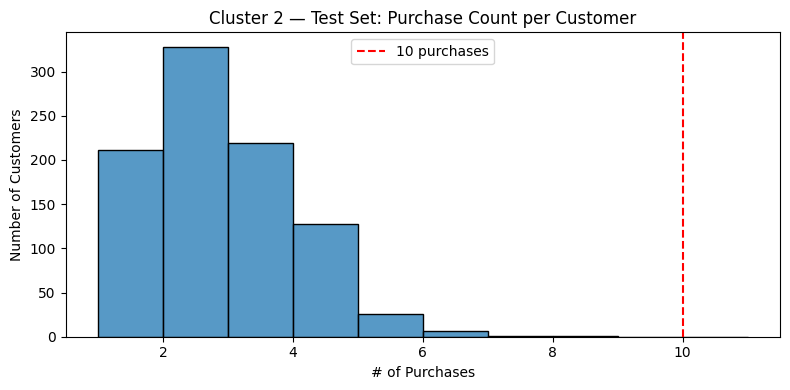


Cluster 3 — Customers: 5258
Min: 1, Max: 2, Mean: 1.47, Median: 1.0
Customers with <10 interactions: 5258 (100.0%)
count    5258.000000
mean        1.472613
std         0.499297
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         2.000000
Name: count, dtype: float64


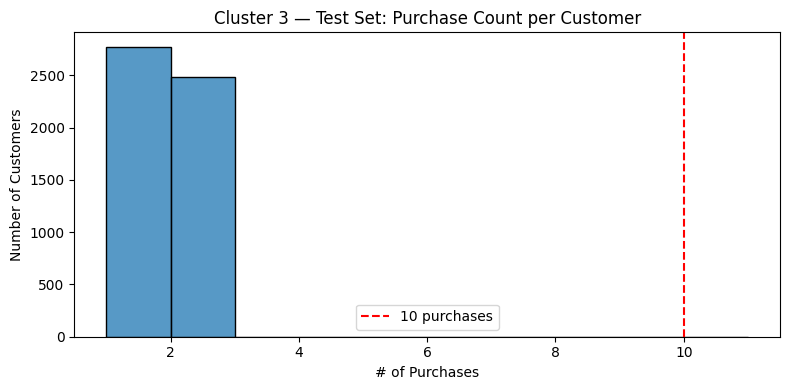

In [ ]:
analyze_customer_activity_distribution_by_cluster(train_data, val_data, split_name='val', k=10)
analyze_customer_activity_distribution_by_cluster(train_data, test_data, split_name='test', k=10)


### Observations:

- 100% of customer in all clusters have fewer than 10 interactions in both validation and test sets.
- Many customers have only 1 or 2 interactions:
  - For example, Cluster 1 in both val and test has exactly 1 interaction for every customer.
  - Cluster 2 has slightly more variation but still a max of 9 (val) and 8 (test).
- Standard deviations are low, especially in Clusters 1 and 3, indicating that almost all customer are at the bare minimum end of the interaction count distribution. This is matches the customer characteristics of clusters 1 (Critical and Disengaged Customers) and 3 (Casual Optimists) as both clusters have the lowest purchasing frequency out of the clusters.

- Max values across all clusters do not exceed 9, making traditional @10 metrics infeasible.

# Step 3: Distribution of Customer Purchases in Filtered Validation and Test Sets (For Non-Clustered, Full Models)

In [ ]:
# Filter validation and test sets based on training customers/products
unique_customers_train = set(train_data['customer_id'].unique())
unique_products_train = set(train_data['product_id'].unique())

val_filtered = val_data[val_data['customer_id'].isin(unique_customers_train) &
                        val_data['product_id'].isin(unique_products_train)].reset_index(drop=True)

test_filtered = test_data[test_data['customer_id'].isin(unique_customers_train) &
                          test_data['product_id'].isin(unique_products_train)].reset_index(drop=True)


In [ ]:
def analyze_customer_interaction_distribution(split_df, split_name="Validation", k=10):
    customer_counts = split_df['customer_id'].value_counts()
    num_customers = customer_counts.shape[0]
    num_under_k = (customer_counts < k).sum()
    percent_under_k = 100 * num_under_k / num_customers if num_customers > 0 else 0

    print(f"\n===== {split_name.upper()} Set (Full Model, Filtered) =====")
    print(f"Total Customers: {num_customers}")
    print(f"Customers with <{k} interactions: {num_under_k} ({percent_under_k:.1f}%)")
    print(f"Min: {customer_counts.min()}, Max: {customer_counts.max()}, Mean: {customer_counts.mean():.2f}, Median: {customer_counts.median()}")
    print(customer_counts.describe())

    plt.figure(figsize=(8, 4))
    sns.histplot(customer_counts, bins=range(1, max(customer_counts.max(), k) + 2), kde=False)
    plt.title(f'{split_name.capitalize()} Set (Filtered) — Purchases per Customer')
    plt.xlabel('# of Purchases')
    plt.ylabel('Number of Customers')
    plt.axvline(k, color='red', linestyle='--', label=f'{k} purchases')
    plt.legend()
    plt.tight_layout()
    plt.show()



===== VALIDATION Set (Full Model, Filtered) =====
Total Customers: 15019
Customers with <10 interactions: 15016 (100.0%)
Min: 1, Max: 10, Mean: 1.14, Median: 1.0
count    15019.000000
mean         1.143485
std          0.504329
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         10.000000
Name: count, dtype: float64


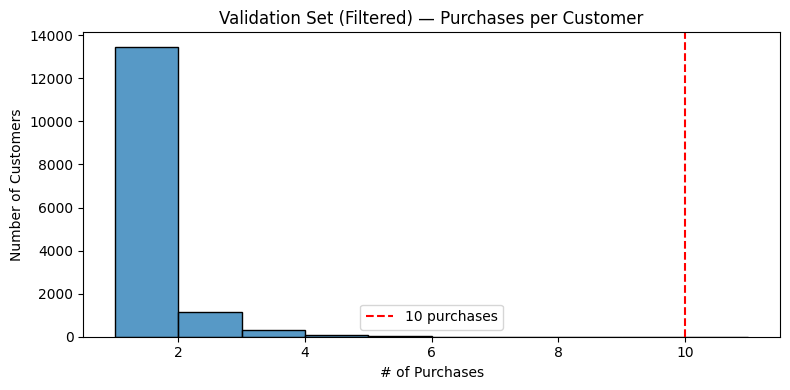


===== TEST Set (Full Model, Filtered) =====
Total Customers: 17249
Customers with <10 interactions: 17246 (100.0%)
Min: 1, Max: 11, Mean: 1.91, Median: 2.0
count    17249.000000
mean         1.906197
std          0.770673
min          1.000000
25%          1.000000
50%          2.000000
75%          2.000000
max         11.000000
Name: count, dtype: float64


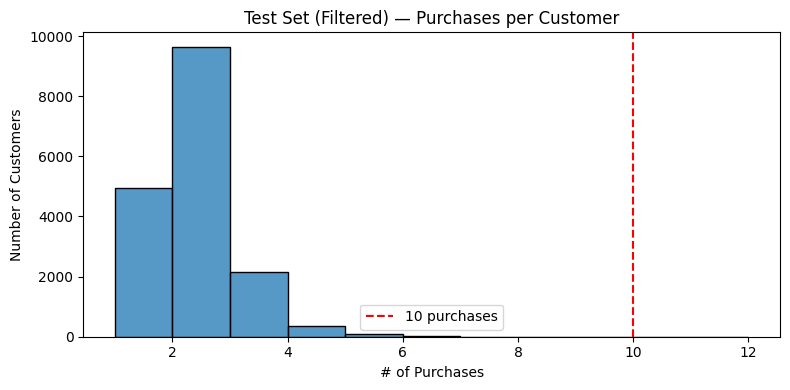

In [ ]:
analyze_customer_interaction_distribution(val_filtered, split_name='Validation', k=10)
analyze_customer_interaction_distribution(test_filtered, split_name='Test', k=10)

### Observations:

**Validation set**:

- 100% of customers (15016 out of 15019) have fewer than 10 interactions.

- Median and 75th percentile are both 1, confirming extreme sparsity.

- Only 1 customer has exactly 10 interactions (max).

**Test set**:

- 99.98% of customers (17246 out of 17249) have fewer than 10 interactions.

- Median = 2, 75th percentile = 2, and max = 11.

- Most customers have only 1 to 2 interactions.

#Conclusion
The purpose of this analysis is to highlight the **sparsity of customer interaction data** in both validation and test sets. Specifically, we show that a large proportion of customer have fewer than 10 interactions, which has significant implications for evaluation.

Traditional @K evaluation metrics (e.g., Precision@10, Recall@10, NDCG@10) assume that each customer has at least K relevant or observed items.
When customer have fewer than K items, these metrics can become biased.

To address this, we modify all @K (Precision, Recall, F1, NDCG) metrics in our model's evaluation by using:
**actual_k = min(K, number of available items for the customer)**.
